## Project - A/B Testing
Author: Piyush Kumar

A/B tests are used to test changes on a web page (from large feature additions to small adjustments in color) by running an experiment where a **control** group sees the old version, while the **experiment** group sees the new version. A **metric or group of metric** is then chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other. A/B testing is very much like hypothesis testing with the following hypotheses:

- **Null Hypothesis:**  The new version is no better, or even worse, than the old version.
- **Alternative Hypothesis:**  The new version is better than the old version.

If we fail to reject the null hypothesis, the results would suggest keeping the old version. If we reject the null hypothesis, the results would suggest launching the change. That's enough background, let's dive in!

### Table of Contents:

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression Approach](#regression)

<a id=intro></a>
### Introduction 

An ecommerce company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Our goal is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision, by analyzing the A/B tests run by company. 

Our metric for this A/B test would be whether the user converts or not. 

<a id=probability></a>
### Part I - Probability 

To get started, let's import our libraries

In [71]:
import pandas as pd
import numpy as np
import random
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# let's setup a random seed so that the results obtanined here don't deviate on future runs of this notebook. 

random.seed(42)

In [3]:
# let's load the a/b test data and take a look into the few top rows.

df=pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# let's get the shape of our dataset.

df.shape

(294478, 5)

In [5]:
# Unique users in our dataset.

df.user_id.nunique()

290584

In [6]:
# Let's check for any duplciate rows we might have.

df.duplicated().sum()

0

In [7]:
# Let's check for any null values we might have.

df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
# let's get a broadview of our dataset. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


We have incorrect datatype here, object type for `timestamp` instead of datetime and int type for `converted` instead of bool. Fixing the datatype is not the objective here, but let's fix the timestamp column so as we can get the runtime of A/B test. 

In [9]:
# Changing timestamp column into datetime type and checking for the changes made. 

df.timestamp=pd.to_datetime(df.timestamp)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [10]:
# Getting the Runtime of A/B test.

df.timestamp.max() - df.timestamp.min()

Timedelta('21 days 23:59:49.081927')

A 22 days of runtime for this A/B test seems satisfactory. 

In [11]:
# We can also see the date-wise distribution of A/B test users. 

df.timestamp.dt.date.value_counts().sort_index()

2017-01-02     5783
2017-01-03    13394
2017-01-04    13284
2017-01-05    13124
2017-01-06    13528
2017-01-07    13381
2017-01-08    13564
2017-01-09    13439
2017-01-10    13523
2017-01-11    13553
2017-01-12    13322
2017-01-13    13238
2017-01-14    13329
2017-01-15    13449
2017-01-16    13327
2017-01-17    13322
2017-01-18    13285
2017-01-19    13293
2017-01-20    13393
2017-01-21    13475
2017-01-22    13423
2017-01-23    13511
2017-01-24     7538
Name: timestamp, dtype: int64

We see a uniform distrubution of A/B test users across days for the running period of the A/B test.

In [12]:
# Let's see if there are any instances where treatment group doesn't match with new_page
# and control group doesn't match with old_page

df[(df['group']=='treatment') & (df['landing_page']!='new_page')].shape[0] + df[(df['group']=='control') & (df['landing_page']!='old_page')].shape[0]

3893

For these 3893 rows, we are not sure if it received the new_page or the old_page. 

In [13]:
# Let's delete these new found instances which otherwise can make our analysis flawed. 

df.drop(df[(df['group']=='treatment') & (df['landing_page']!='new_page')].index, inplace=True)
df.drop(df[(df['group']=='control') & (df['landing_page']!='old_page')].index, inplace=True)

In [14]:
# Checking if correct rows are removed - the following expression should be zero. 

df[(df['group']=='treatment') & (df['landing_page']!='new_page')].shape[0] + df[(df['group']=='control') & (df['landing_page']!='old_page')].shape[0]

0

In [15]:
# Duplicate users in our dataset.

df.user_id.duplicated().sum()

1

In [16]:
# Bringing up that duplicate user_id.

df[df.user_id.duplicated()==True].user_id

2893    773192
Name: user_id, dtype: int64

In [17]:
# Inspecting all the rows of the duplicate user_id.

df[df.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Both the entries above are indifferent to `group`, `landing_page` and `converted`. We can remove any of these rows. Phew!

In [18]:
# Dropping the row with duplicate user_id.

df.drop_duplicates('user_id', inplace=True)
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [19]:
# Let's see how many unique users we have now.

df.user_id.nunique()

290584

In [20]:
# Probability of users who got converted, regardless of the type of the landing_page they received.

df.converted.mean()

0.11959708724499628

In [21]:
# Probability of control group users who got convereted

control=df[df.group =='control']
control.converted.mean()

0.1203863045004612

In [22]:
# Probability of treatment group users who got convereted

treatment=df[df.group=='treatment']
treatment.converted.mean()

0.11880806551510564

In [23]:
# Probability that a user receives the new_page.

df[df.landing_page =='new_page'].shape[0]/df.shape[0]

0.5000619442226688

In [24]:
# No. of users in the control group. 

n_old = control.shape[0]
n_old

145274

In [25]:
# No. of users in the treatment group. 

n_new = treatment.shape[0]
n_new

145310

Almost equal no. of users in our control and treatment group, and a 50% probability of an user receiving the new page indicates that we have balancned set of users in both the groups and an equally likely probability of getting either of the two pages. However, the probabilty of conversion is even lower with the new page than the old page, and is also the same as the probabilty of conversion irrespective of page, hence it's not a good idea to implement the new page design. 

<a id='ab_test'></a>
### Part II - A/B Test

We want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.
<br>This sets up our null and alternative hypothesis like:

$$ H_0: p_{new} <= p_{old}$$

$$ H_1: p_{new} > p_{old}$$

$$\alpha = 0.05$$

Where $p_{new}$ and $p_{old}$ are the converted rate for the `new_page` and `old_page` respectively.

Since our motive is to find which page has more conversion rate, let's assume under the null hypothesis that, $p_{new}$ and $p_{old}$ both have equal conversion rates. Furthermore, assume they are equal to the **converted** rate in our **ab_data.csv** dataset regardless of the page. <br><br>

In [26]:
# In line with our assumption, the conversion rate for p_new under the null

p_new = df.converted.mean()
p_new

0.11959708724499628

In [27]:
# And, the conversion rate for the p_old under the null

p_old = df.converted.mean()
p_old

0.11959708724499628

In [36]:
# No. of users in the control and treatment group. 

n_old, n_new

(145274, 145310)

In [49]:
# let's simulate n_old transactions with a conversion rate of p_old under the null

old_page_converted = np.random.choice(2, size=n_old, p=[1-p_old,p_old])
old_page_converted

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [50]:
# let's simulate n_new transactions with a conversion rate of p_new under the null

new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new, p_new])
new_page_converted

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [51]:
# Observed difference in the simulated conversion rates for the old_page and the new_page

obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.0011131312957196743

In [53]:
# let's perform a sampling distribution of the difference in conversion rates 
# for the new_page and old_page over 10000 iterations 

p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice(2, size=n_old, p=[1-p_old, p_old])
    obs_diff_sample = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(obs_diff_sample)

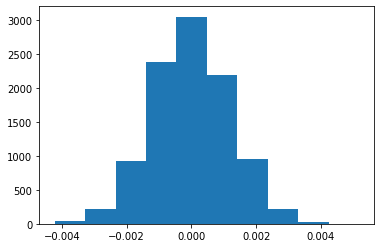

In [65]:
# Let's plot this simulated difference in conversion rates.

p_diffs=np.array(p_diffs)
plt.hist(p_diffs);

The sampling distribution for our statistic (diff. in means) is normally distributed. This confirms that our sample size conforms to central limit theorem.  

In [61]:
# Let's compute the proportion of p_diffs that is greater than the 
# actual difference observed for the conversion rates in our dataset

(p_diffs> (treatment.converted.mean() - control.converted.mean())).mean()

0.9069

This is called p-value. The probability of observing our statistic from the null hypothesis.
We'd set up our hypothesis with the type-I error rate of 0.05, and the obtained p-value is large enough and greater than $\alpha$ as well, so we fail to reject the null.
And hence, we have the evidence that with a type I error rate of 0.05 old_page has higher or equal probablity of converting than the new_page.


Let's use a built-in `stats.proportions_ztest` from statsmodels library to achieve similar results

In [68]:
# Let's get the count of conversions for old_page and new_page

convert_old = control[control['converted']==1].shape[0]
convert_new = treatment[treatment['converted']==1].shape[0]

In [70]:
# Now, let's run the Z-statistic test to get the z-score and p_value

z_score, p_value = sm.stats.proportions_ztest(np.array([convert_old,convert_new]),np.array([n_old,n_new]), alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [69]:
#Let's see what's the critical value is at our z-score:

from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

Since our z-score of 1.3109241984234394 is not more than the critical value of z-score of 1.959963984540054. We fail to reject the null hypothesis that new page users has a better or equal converted rate than old page users. Also, the p_value is large enough that we fail to reject our null hypothesis. 

And hence, we have the evidence that with a type I error rate of 0.05 old_page has higher or equal probablity of converting than the new_page.

<a id=regression></a>
### Part III - Regression Approach

Results obtained via A/B test can also be achieved by performing regression.

Since each row is either a conversion or no conversion, i.e our target variable is of categorical type, we will use Logistics regression in this case. 

In [72]:
# Creating a dummy variable ab_page which will be 1 if the user receives the new_page and 0 if old_page 

df['ab_page'] = pd.get_dummies(df['group'])['treatment']
df.sample(5)

,user_id,timestamp,group,landing_page,converted,ab_page
215191,907982,2017-01-23 04:19:34.773108,treatment,new_page,0,1
140268,844643,2017-01-19 01:46:06.193214,control,old_page,1,0
47432,866373,2017-01-05 05:07:30.633476,treatment,new_page,0,1
228975,762608,2017-01-11 11:04:34.121551,control,old_page,0,0
50074,679492,2017-01-09 14:07:23.918512,control,old_page,0,0


In [83]:
# let's build the logistics regression model

df['intercept']= 1  
model = sm.Logit(df['converted'], df[['intercept','ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [84]:
# let's get the summary statistics for our model

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:28:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value here is 0.190. It differs from the previous as the hypotheses are different for this regression approach.
The null hypothesis here is that there is no difference between the treatment and control group.
Alternative hypotheses is that there is difference between the treatment and control group. Since, the p-value here is greater than the type-I error rate threshold ($\alpha$) of 0.05, we fail to reject the null hypothesis. 

<br>

We can also consider impact of other factors that might influence whether or not an user converts. Among other factors to consider, we can go with duration i.e timestamp variable, location of the user. Viability of the same is a tradeoff between performance gain and the question that if we really need that added complexity into the model. Though, adding additional factors into your model might lead to better prediction, it will also make the model complex, will take longer time to train and is generally not a good idea to go with if the performance gains aren't big enough. 

Let's test the above idea and include the country of the user in our regression model and see if there's an impact on the conversion based on which country a user lives in.  

In [85]:
# let's read in the countries dataset

countries=pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [99]:
# let's do some basic checks

countries.isnull().sum()

user_id    0
country    0
dtype: int64

No missing values! Sorted.

In [100]:
# Let's see how many unique users we have here.

countries.user_id.nunique()

290584

This is equal to the no. of unique users in our `ab_data.csv`

In [101]:
# Getting the no. of users from each country

countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [102]:
# let's merge the two datasets on user_id as the primary key. 

df2 = df.merge(countries, on ='user_id', how='left')
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [106]:
# let's see how many users got converted from each country

df2[df2['converted']==1].groupby(['country'])['converted'].sum()

country
CA     1672
UK     8739
US    24342
Name: converted, dtype: int64

In [113]:
# Creating dummy variables for the each of the three countries CA, US and UK

df2['country_CA'] = pd.get_dummies(df2['country'])['CA']
df2['country_UK'] = pd.get_dummies(df2['country'])['UK']
df2.sample(10)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,country_CA,country_UK
6880,871290,2017-01-06 14:19:16.439134,control,old_page,0,0,1,UK,0,1
238351,889782,2017-01-23 13:28:00.339523,control,old_page,0,0,1,US,0,0
27483,945423,2017-01-03 19:03:23.983641,treatment,new_page,0,1,1,UK,0,1
124856,796523,2017-01-16 18:56:32.556205,treatment,new_page,0,1,1,UK,0,1
2682,658478,2017-01-16 04:08:50.963618,control,old_page,0,0,1,US,0,0
187257,835802,2017-01-10 23:04:24.421868,treatment,new_page,0,1,1,US,0,0
269920,864890,2017-01-04 17:53:12.025636,control,old_page,0,0,1,US,0,0
142804,806714,2017-01-12 10:13:14.713968,control,old_page,0,0,1,US,0,0
229976,639081,2017-01-11 19:04:03.827149,control,old_page,0,0,1,US,0,0
49177,703778,2017-01-02 13:52:44.656037,treatment,new_page,0,1,1,US,0,0


In [116]:
# let's instantiate and fit the logistics model.

model2 = sm.Logit(df2['converted'], df2[['intercept','ab_page', 'country_CA', 'country_UK']])
results2 = model2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [117]:
# let's get the summary statistics for our model

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        20:47:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
country_CA    -0.0408      0.027     -1.516      0.130      -0.093       0.012
country_UK     0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

None of the individual factors above have a p-value of less than the type-I error rate threshold ($\alpha$) of 0.05. 
We cannot conclude that the country, page type and conversions are co-related.

Moving from individual factors, now let's see if the interaction terms has any effect on conversion. Let's fit a new model to include the interaction between countries and page type.

In [118]:
# let's create the interaction terms out of dummy variables of countries and ab_page, and then fit the new model.

df2['ab_CA'] = df2['ab_page'] * df2['country_CA']
df2['ab_UK'] = df2['ab_page'] * df2['country_UK']

model3 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'ab_CA', 'ab_UK']])
results3 = model3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [119]:
# let's get the summary statistics for our model

results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 16 Jul 2020   Pseudo R-squ.:               3.351e-05
Time:                        00:41:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0183      0.013     -1.449      0.147      -0.043       0.006
ab_CA         -0.0644      0.038     -1.679      0.093      -0.140       0.011
ab_UK          0.0257      0.019      1.363      0.173      -0.011       0.063
==============================================================================
"""

Again, none of the interaction terms above has a p-value of less than the type-I error rate threshold ( 𝛼 ) of 0.05. We cannot conclude that the interaction between country and page type results in a conversions or not.

<a id=conclusion></a>
### Conclusion

Based on the results obtained from different approaches, we conclude that we don't have sufficient evidence to prove that implementing `new_page` will lead to more conversion than the `old_page`. 

Hence, the recommendation is to not launch the new page design and keep up with the old design. 